In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk
import tensorflow as tf
from tensorflow.keras.layers import (Input, Embedding, Conv1D, GlobalMaxPooling1D,
                                     Bidirectional, LSTM, Dense, Dropout, concatenate,MaxPooling1D,Attention,Add,Flatten,LayerNormalization,GlobalAveragePooling1D,ZeroPadding1D)
from tensorflow.keras.models import Model
from keras.src.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Lambda

from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score
from tensorflow import keras
from collections import Counter
from tensorflow.keras.metrics import AUC, Precision, Recall

import torch
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel
import transformers



In [3]:
device_name = tf.test.gpu_device_name()

if "GPU" not in device_name:
    print("GPU device not found")

print('Found GPU at: {}'.format(device_name))

print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")


Found GPU at: /device:GPU:0
GPU available (YESS!!!!)


In [4]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [5]:
strategy = tf.distribute.MirroredStrategy()
print(f'Number of devices: {strategy.num_replicas_in_sync}')

Number of devices: 1


In [6]:
df = pd.read_csv(r'/content/drive/MyDrive/Capstone/Data/Train/ShortCVE.csv')

In [7]:
df.head(5)

,Unnamed: 0,code,language,safety
0,0,package org.bouncycastle.jcajce.provider.asymm...,1,1
1,1,<?php\n\n\n\n/**\n\n * ownCloud - user_ldap\n\...,3,1
2,2,#!/usr/bin/env python\n\nfrom __future__ impor...,4,0
3,3,/* -*- c-basic-offset: 8 -*-\n\n rdesktop: A...,0,0
4,6,/*\n\n ettercap -- GTK+ GUI\n\n\n\n Copy...,0,1


In [8]:
df = df.drop(['Unnamed: 0'],axis=1)

In [9]:

# # Loop over a few sample rows to see a side-by-side comparison
# for index, row in df.sample(5).iterrows():
#     print("Row index:", index)
#     print("Vulnerable Code:\n", row[1])
#     print("Safe code:\n", row[0])
#     print("-" * 40)


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18509 entries, 0 to 18508
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   code      18509 non-null  object
 1   language  18509 non-null  int64 
 2   safety    18509 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 433.9+ KB


In [11]:
df.isna().sum()

,0
code,0
language,0
safety,0


In [12]:
df.describe()

,language,safety
count,18509.000000,18509.000000
mean,1.475444,0.500027
std,1.514323,0.500014
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,1.000000
75%,3.000000,1.000000
max,4.000000,1.000000


In [13]:
df.shape

(18509, 3)

In [14]:
df2 = df.iloc[:500]

In [15]:
df2.shape

(500, 3)

In [16]:
df2.head()

,code,language,safety
0,package org.bouncycastle.jcajce.provider.asymm...,1,1
1,<?php\n\n\n\n/**\n\n * ownCloud - user_ldap\n\...,3,1
2,#!/usr/bin/env python\n\nfrom __future__ impor...,4,0
3,/* -*- c-basic-offset: 8 -*-\n\n rdesktop: A...,0,0
4,/*\n\n ettercap -- GTK+ GUI\n\n\n\n Copy...,0,1


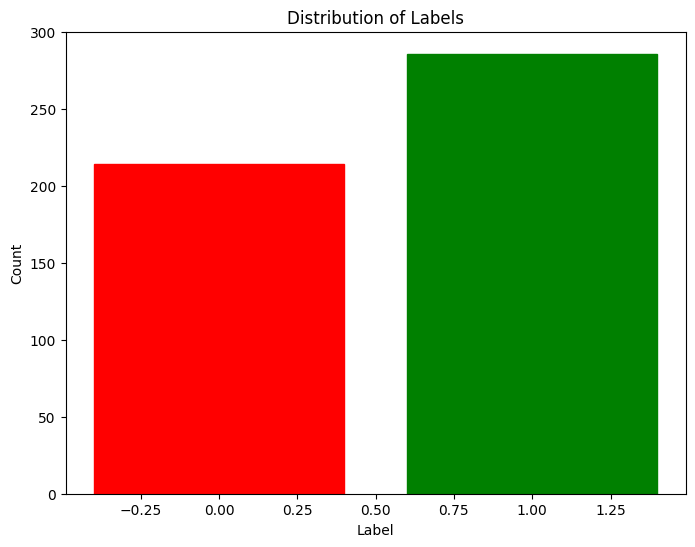

In [17]:



# Assuming 'label' column exists in your DataFrame 'df'

# Count the occurrences of each label
label_counts = df2['safety'].value_counts()

# Create the bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(label_counts.index, label_counts.values)

# Set colors for bars
bars[0].set_color('green')  # Color for label 0
bars[1].set_color('red')   # Color for label 1

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()


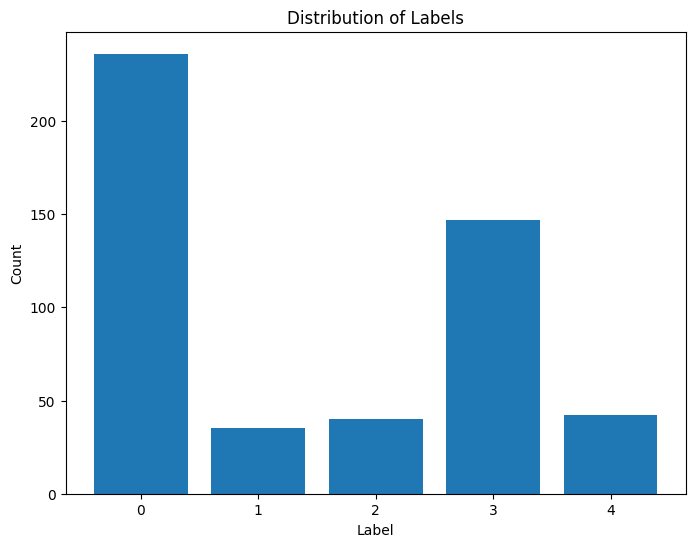

In [18]:



# Assuming 'label' column exists in your DataFrame 'df'

# Count the occurrences of each label
label_counts = df2['language'].value_counts()

# Create the bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(label_counts.index, label_counts.values)



plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()


In [19]:
!pip install datasets

In [20]:
from datasets import Dataset

In [21]:
#Converting the Pandas Dataframe to a HF dataset
dataset = Dataset.from_pandas(df2)

**Tokenization Process**

In [22]:
def sliding_window_text(code_str, window_size=200, step_size=50):
    """
    Splits a code string into overlapping segments using a sliding window.

    :param code_str: The entire code as a string.
    :param window_size: Number of characters per window.
    :param step_size: How far to move between windows.
    :return: A list of overlapping code snippets.
    """
    snippets = []
    length = len(code_str)

    # If shorter than the window, just return the whole snippet
    if length <= window_size:
        return [code_str]

    # Move the window in increments of step_size
    start = 0
    while start < length - window_size + 1:
        snippet = code_str[start:start + window_size]
        snippets.append(snippet)
        start += step_size

    # Optionally, include the last window if it doesn't perfectly align
    if start < length:
        # If you want the last chunk to be exactly window_size in length:
        # snippets.append(code_str[-window_size:])

        # Or if you want a shorter trailing snippet:
        snippets.append(code_str[start:])

    return snippets


In [23]:
def sliding_map_function(batch):
    """
    batch: dict of lists for keys "code", "language", "safety"
    Returns expanded lists of code, language, safety with each snippet as a new example.
    """
    new_codes = []
    new_langs = []
    new_safeties = []

    # We'll iterate over each item in the batch
    for code_str, lang, safe in zip(batch["code"], batch["language"], batch["safety"]):
        # Apply the sliding window to the code string
        snippets = sliding_window_text(code_str, window_size=200, step_size=50)

        # Each snippet inherits the same language & safety labels
        for snippet in snippets:
            new_codes.append(snippet)
            new_langs.append(lang)
            new_safeties.append(safe)

    # Return lists with the same length
    return {
        "code": new_codes,
        "language": new_langs,
        "safety": new_safeties
    }


In [24]:
dataset_slid = dataset.map(
    sliding_map_function,
    batched=True,
    remove_columns=dataset.column_names  # remove original columns so we only keep new ones
)

# val_slid = val_dataset.map(
#     sliding_map_function,
#     batched=True,
#     remove_columns=val_dataset.column_names
# )

print("Train dataset after sliding window:")
print(dataset_slid)




Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Train dataset after sliding window:
Dataset({
    features: ['code', 'language', 'safety'],
    num_rows: 387227
})


In [25]:
dataset_slid.shape

(387227, 3)

In [26]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [27]:
def tokenize_function(examples):
    # Tokenize the text with padding and truncation
    return tokenizer(examples['code'],
                     padding='max_length',
                     max_length =512,
                    return_tensors='tf',
                     truncation=True)

# Apply the tokenizer to both the training and validation datasets
dataset_slid = dataset_slid.map(tokenize_function, batched=True)


Map:   0%|          | 0/387227 [00:00<?, ? examples/s]

In [33]:
# Split the dataset: 70% training, 30% validation
split_dataset = dataset_slid.train_test_split(test_size=0.3,seed=42)

# Access training and validation datasets
train_dataset = split_dataset['train']
val_dataset = split_dataset['test']


In [34]:
print(train_dataset)
print(val_dataset)

Dataset({
    features: ['code', 'language', 'safety', 'input_ids', 'attention_mask'],
    num_rows: 271058
})
Dataset({
    features: ['code', 'language', 'safety', 'input_ids', 'attention_mask'],
    num_rows: 116169
})


In [41]:
train2= train_dataset

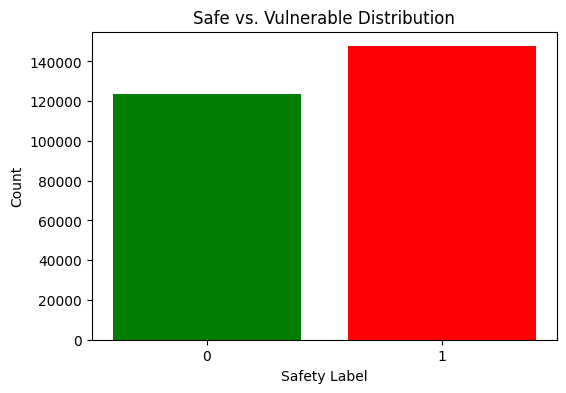

In [42]:


# Suppose train2['safety'] is a Python list:
safety_list = train2["safety"]

# Turn it into a Pandas Series
safety_series = pd.Series(safety_list, name="safety")

# Now you can call .value_counts()
label_counts = safety_series.value_counts().sort_index()

# And plot
plt.figure(figsize=(6,4))
bars = plt.bar(label_counts.index.astype(str), label_counts.values, color=["green","red"])
plt.xlabel("Safety Label")
plt.ylabel("Count")
plt.title("Safe vs. Vulnerable Distribution")
plt.show()


In [43]:
print(label_counts)

safety
0    123457
1    147601
Name: count, dtype: int64


In [44]:
# # Shuffle the datasets separately
train_dataset = train_dataset.shuffle(seed=42)
val_dataset = val_dataset.shuffle(seed=42)


In [45]:
print('Train:', train_dataset.shape)
print('Val:', val_dataset.shape)

Train: (271058, 5)
Val: (116169, 5)


**Model Development**

In [46]:
# Convert 'input_ids' and 'labels' into NumPy arrays for training
X_train_input_ids = np.array(train_dataset['input_ids'])
X_train_attention_mask = np.array(train_dataset['attention_mask'])
y_train_lang=np.array(train_dataset['language'])
y_train_safety = np.array(train_dataset['safety'])

X_val_input_ids = np.array(val_dataset['input_ids'])
X_val_attention_mask = np.array(val_dataset['attention_mask'])
y_val_lang = np.array(val_dataset['language'])
y_val_safety = np.array(val_dataset['safety'])


In [48]:
print("Train input_ids shape:", X_train_input_ids.shape)
print("Train attention_mask shape:", X_train_attention_mask.shape)
print("Train lang shape:", y_train_lang.shape)
print("Train safety shape:", y_train_safety.shape)

print()

print("Validation Input_ids shape:", X_val_input_ids.shape)
print("Validation attention_mask shape:", X_val_attention_mask.shape)
print("Validation lang shape:", y_val_lang.shape)
print("Validation safety shape:", y_val_safety.shape)



Train input_ids shape: (271058, 512)
Train attention_mask shape: (271058, 512)
Train lang shape: (271058,)
Train safety shape: (271058,)

Validation Input_ids shape: (116169, 512)
Validation attention_mask shape: (116169, 512)
Validation lang shape: (116169,)
Validation safety shape: (116169,)


In [52]:
from transformers import TFRobertaModel

In [53]:
class CodeBertLayer(tf.keras.layers.Layer):

    def __init__(self, model_name="microsoft/codebert-base", **kwargs):
        super().__init__(**kwargs)
        self.codebert = TFRobertaModel.from_pretrained(model_name)
        self.codebert.trainable = True

    def call(self, inputs, **kwargs):
        input_ids, attention_mask = inputs
        # Ensure the input shapes are consistent
        tf.debugging.assert_equal(
            tf.shape(input_ids),
            tf.shape(attention_mask),
            message="Input IDs and Attention Mask must have the same shape!"
        )
        outputs = self.codebert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state  # Shape: (batch_size, sequence_length, hidden_size)


In [56]:
def model_architecture(max_length=512,
                       cnn_filters=162,
                       num_neurons=250,
                       dropout_rate=0.3,
                       l2_reg=0.002,
                       num_classes_language=5,
                       num_classes_safety=2):

    # Inputs
    input_ids = Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')

    # BERT embeddings
    bert_embedding = CodeBertLayer()([input_ids, attention_mask])

    # ====================
    # Language Branch
    # ====================
    # CNN Block for language branch
    cnn1 = Conv1D(filters=cnn_filters, kernel_size=3, padding='same', strides=1, activation='relu')(bert_embedding)
    cnn1 = MaxPooling1D(pool_size=2, padding='same')(cnn1)
    cnn1 = BatchNormalization()(cnn1)

    cnn2 = Conv1D(filters=cnn_filters, kernel_size=3, padding='same', strides=1, activation='relu')(cnn1)
    cnn2 = MaxPooling1D(pool_size=2, padding='same')(cnn2)
    cnn2 = BatchNormalization()(cnn2)
    cnn2 = Dropout(dropout_rate)(cnn2)
    cnn2 = GlobalAveragePooling1D()(cnn2)

    # BiLSTM Block for language branch
    bilstm1 = Bidirectional(LSTM(num_neurons, return_sequences=True))(bert_embedding)
    bilstm1 = LayerNormalization()(bilstm1)
    bilstm1 = Dropout(dropout_rate)(bilstm1)

    bilstm2 = Bidirectional(LSTM(num_neurons, return_sequences=True))(bilstm1)
    bilstm2 = LayerNormalization()(bilstm2)
    bilstm2 = Dropout(dropout_rate)(bilstm2)

    # Attention on BiLSTM outputs
    attention = Attention()([bilstm2, bilstm2])
    attention = GlobalMaxPooling1D()(attention)

    merged_lang = concatenate([cnn2, attention])

    fc1 = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(merged_lang)
    fc1 = LayerNormalization()(fc1)
    fc1 = Dropout(dropout_rate)(fc1)

    # Language output (softmax for multi-class)
    language_output = Dense(num_classes_language, activation='softmax', name='language_output')(fc1)


    # ====================
    # Safety Branch (Dedicated)
    # ====================
    # CNN Block for safety branch
    cnn3 = Conv1D(filters=cnn_filters, kernel_size=3, padding='same', strides=1, activation='relu')(bert_embedding)
    cnn3 = MaxPooling1D(pool_size=2, padding='same')(cnn3)
    cnn3 = BatchNormalization()(cnn3)

    cnn4 = Conv1D(filters=cnn_filters, kernel_size=3, padding='same', strides=1, activation='relu')(cnn3)
    cnn4 = MaxPooling1D(pool_size=2, padding='same')(cnn4)
    cnn4 = BatchNormalization()(cnn4)
    cnn4 = Dropout(dropout_rate)(cnn4)
    cnn4 = GlobalAveragePooling1D()(cnn4)

    # BiLSTM Block for safety branch
    bilstm4 = Bidirectional(LSTM(num_neurons, return_sequences=True))(bert_embedding)
    bilstm4 = LayerNormalization()(bilstm4)
    bilstm4 = Dropout(dropout_rate)(bilstm4)

    bilstm5 = Bidirectional(LSTM(num_neurons, return_sequences=True))(bilstm4)
    bilstm5 = LayerNormalization()(bilstm5)
    bilstm5 = Dropout(dropout_rate)(bilstm5)

    # Attention on safety BiLSTM outputs
    attention2 = Attention()([bilstm5, bilstm5])
    attention2 = GlobalAveragePooling1D()(attention2)

    # Merge the CNN and BiLSTM paths for safety
    merged_safe = concatenate([cnn4, attention2])

    fc2 = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(merged_safe)
    fc2 = LayerNormalization()(fc2)
    fc2 = Dropout(dropout_rate)(fc2)

    # Extra hidden layer dedicated to safety prediction
    safety_branch = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(fc2)
    safety_branch = LayerNormalization()(safety_branch)
    safety_branch = Dropout(dropout_rate)(safety_branch)

    # Safety output (1 neuron with sigmoid for binary classification)
    safety_output = Dense(1, activation='sigmoid', name='safety_output')(safety_branch)

    # Define model with both outputs
    model = Model(inputs=[input_ids, attention_mask], outputs=[language_output, safety_output])

    optimizer = Adam(learning_rate=1e-4, clipvalue=1.0)
    model.compile(optimizer=optimizer,
                  loss={'language_output': 'sparse_categorical_crossentropy',
                        'safety_output': 'binary_crossentropy'},
                  loss_weights={'language_output': 0.5, 'safety_output': 1.5},
                  metrics={'language_output': 'accuracy',
                           'safety_output': ['accuracy', AUC(), Precision(), Recall()]})
    return model


In [57]:
with strategy.scope():
    model = model_architecture(max_length=512)
    model.summary()


tf_model.h5:   0%|          | 0.00/499M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at microsoft/codebert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ code_bert_layer     │ (None, 512, 768)  │          0 │ input_ids[0][0],  │
│ (CodeBertLayer)     │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 512, 162)  │    373,410 │ code_bert_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 512, 500)  │  2,038,000 │ code_bert_layer[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 256, 162)  │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 512, 500)  │      1,000 │ bidirectional_2[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 162)  │        648 │ max_pooling1d_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 512, 500)  │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 512, 162)  │    373,410 │ code_bert_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 512, 500)  │  2,038,000 │ code_bert_layer[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 256, 162)  │     78,894 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 512, 500)  │  1,502,000 │ dropout_5[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 256, 162)  │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 512, 500)  │      1,000 │ bidirectional[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 128, 162)  │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 512, 500)  │      1,000 │ bidirectional_3[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 162)  │        648 │ max_pooling1d[0]… │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 8,178,982 (31.20 MB)

 Trainable params: 8,177,686 (31.20 MB)

 Non-trainable params: 1,296 (5.06 KB)

In [61]:
mkdir = 'logs'

In [62]:
logdir = 'logs'

In [63]:
#Early Stopping to avoid overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        'best_vulnerability_model.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='max',
        save_weights_only=False,
        verbose=1
    )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=0.00001,
        verbose=1
    )



In [64]:
history = model.fit(x=[X_train_input_ids, X_train_attention_mask],
                    y=[y_train_lang, y_train_safety],
                    validation_data=([X_val_input_ids, X_val_attention_mask], [y_val_lang, y_val_safety]),
                    epochs=10,
                    batch_size=64,
                    callbacks=[early_stopping, model_checkpoint, tensorboard_callback,reduce_lr],
                    verbose=1)


Epoch 1/10
4236/4236 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - language_output_accuracy: 0.9364 - language_output_loss: 0.1952 - loss: 1.8930 - safety_output_accuracy: 0.5614 - safety_output_auc: 0.5787 - safety_output_loss: 0.6886 - safety_output_precision: 0.5821 - safety_output_recall: 0.6867
Epoch 1: val_loss improved from -inf to 1.25846, saving model to best_vulnerability_model.keras
4236/4236 ━━━━━━━━━━━━━━━━━━━━ 2822s 662ms/step - language_output_accuracy: 0.9364 - language_output_loss: 0.1952 - loss: 1.8929 - safety_output_accuracy: 0.5614 - safety_output_auc: 0.5787 - safety_output_loss: 0.6886 - safety_output_precision: 0.5821 - safety_output_recall: 0.6867 - val_language_output_accuracy: 0.9807 - val_language_output_loss: 0.0585 - val_loss: 1.2585 - val_safety_output_accuracy: 0.6340 - val_safety_output_auc: 0.7335 - val_safety_output_loss: 0.6509 - val_safety_output_precision: 0.6045 - val_safety_output_recall: 0.9462 - learning_rate: 1.0000e-04
Epoch 2/10
4236/4236 ━━━━━━━━━━━

In [65]:
# Obtain probabilities from the model (returns a list of two arrays)
pred_lang_prob, pred_safety_prob = model.predict([X_val_input_ids, X_val_attention_mask])

# For each output, get the index with the highest probability
pred_lang_labels = np.argmax(pred_lang_prob, axis=1)
# if pred_safety_prob is shape (N, 1)
pred_safety_labels = (pred_safety_prob.flatten() > 0.5).astype(int)



3631/3631 ━━━━━━━━━━━━━━━━━━━━ 796s 218ms/step


In [66]:
from sklearn.metrics import f1_score

f1_lang = f1_score(y_val_lang, pred_lang_labels, average='macro')
f1_safety = f1_score(y_val_safety, pred_safety_labels, average='binary')

print("F1 Score for Language Classification:", f1_lang)
print("F1 Score for Safety Classification:", f1_safety)


F1 Score for Language Classification: 0.9866833199705626
F1 Score for Safety Classification: 0.8721864467982667


In [67]:
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

In [68]:
# y_val_safety should be your ground‑truth 0/1 array of length N
f1 = f1_score(y_val_safety, pred_safety_labels)
prec = precision_score(y_val_safety, pred_safety_labels)
rec  = recall_score(y_val_safety, pred_safety_labels)

print(f"Safety → Precision: {prec:.3f}, Recall: {rec:.3f},  F1: {f1:.3f}\n")
print("Full classification report:\n",
      classification_report(y_val_safety, pred_safety_labels, target_names=["safe","vulnerable"]))

Safety → Precision: 0.831, Recall: 0.918,  F1: 0.872

Full classification report:
               precision    recall  f1-score   support

        safe       0.89      0.78      0.83     52988
  vulnerable       0.83      0.92      0.87     63181

    accuracy                           0.85    116169
   macro avg       0.86      0.85      0.85    116169
weighted avg       0.86      0.85      0.85    116169



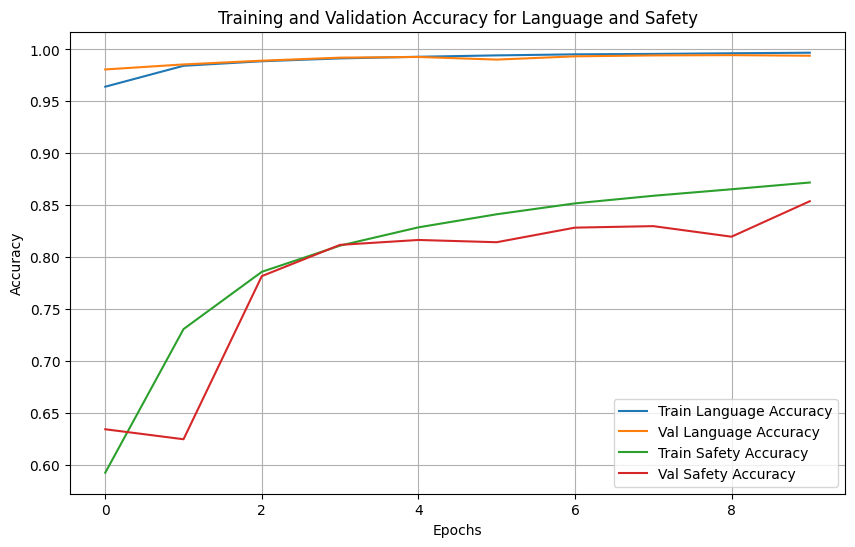

In [69]:
plt.figure(figsize=(10, 6))

# Language output accuracies
plt.plot(history.history['language_output_accuracy'], label='Train Language Accuracy')
plt.plot(history.history['val_language_output_accuracy'], label='Val Language Accuracy')

# Safety output accuracies
plt.plot(history.history['safety_output_accuracy'], label='Train Safety Accuracy')
plt.plot(history.history['val_safety_output_accuracy'], label='Val Safety Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Language and Safety')
plt.legend()
plt.grid(True)
plt.show()


In [70]:


# 1) Load the same tokenizer you used in training
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")

# 2) Define some test snippets
TEST_SNIPPETS = [
    # a likely-vulnerable Python snippet (SQLi)
    """
import sqlite3
def get_user(username):
    conn = sqlite3.connect('users.db')
    c = conn.cursor()
    # vulnerable: string concatenation
    c.execute("SELECT * FROM users WHERE name = '" + username + "'")
    return c.fetchall()
""",
    # a safe Python snippet
    """
def safe_add(a, b):
    # uses parameter binding
    import sqlite3
    conn = sqlite3.connect('users.db')
    c = conn.cursor()
    c.execute("SELECT * FROM users WHERE name = ?", (a,))
    return c.fetchall()
""",
    # a Java example
    """
public class HelloWorld {
  public static void main(String[] args) {
    System.out.println("Hello, world!");
  }
}
""",
]

# 3) Tokenize in one batch (padding & truncation to max_length=512)
enc = tokenizer(
    TEST_SNIPPETS,
    padding="max_length",
    truncation=True,
    max_length=512,
    return_tensors="tf"
)

input_ids      = enc["input_ids"]      # shape (batch, 512)
attention_mask = enc["attention_mask"] # shape (batch, 512)

# 4) Call your model
lang_logits, safety_logits = model.predict([input_ids, attention_mask])

# 5) Convert to hard labels
lang_preds = np.argmax(lang_logits, axis=1)            # e.g. [3, 2, 1]
safety_preds = (safety_logits.flatten() > 0.5).astype(int)

# 6) Map your label IDs back to human names
LANG_ID2NAME = {
    0: "c",
    1: "java",
    2:"JS",
    3: "php",
    4: "python",
}

# 7) Print results
for i, code in enumerate(TEST_SNIPPETS):
    lang_id  = lang_preds[i]
    saf_id   = safety_preds[i]
    lang_prob= float(lang_logits[i, lang_id])
    saf_prob = float(safety_logits[i])  # sigmoid→prob

    print(f"\n--- Sample #{i+1} ---")
    print(code.strip()[:200].replace("\n","⏎")+"…")  # first 200 chars
    print(f"→ Predicted language:   {LANG_ID2NAME[lang_id]}  (p={lang_prob:.2f})")
    print(f"→ Predicted vulnerability:  {'VULNERABLE' if saf_id else 'SAFE'}  (p={saf_prob:.2f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

--- Sample #1 ---
import sqlite3⏎def get_user(username):⏎    conn = sqlite3.connect('users.db')⏎    c = conn.cursor()⏎    # vulnerable: string concatenation⏎    c.execute("SELECT * FROM users WHERE name = '" + username…
→ Predicted language:   python  (p=1.00)
→ Predicted vulnerability:  VULNERABLE  (p=0.84)

--- Sample #2 ---
def safe_add(a, b):⏎    # uses parameter binding⏎    import sqlite3⏎    conn = sqlite3.connect('users.db')⏎    c = conn.cursor()⏎    c.execute("SELECT * FROM users WHERE name = ?", (a,))⏎    return c.…
→ Predicted language:   python  (p=1.00)
→ Predicted vulnerability:  VULNERABLE  (p=0.95)

--- Sample #3 ---
public class HelloWorld {⏎  public static void main(String[] args) {⏎    System.out.println("Hello, world!");⏎  }⏎}…
→ Predicted language:   java  (p=1.00)
→ Predicted vulnerability:  VULNERABLE  (p=0.99)


<ipython-input-70-36dfb1bfe585>:69: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  saf_prob = float(safety_logits[i])  # sigmoid→prob
